# Study of Common XAI Algos in the Literature

In [1]:
import pandas as pd
import numpy as np
import lime
import os
import time

from data.DatasetLoader import Dataset
from Constants import Constants
from learning.Learner import Learner
from learning.BayesianNet import BayesianNet



import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as expl

from IPython.display import display, HTML, Latex

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rcParams['figure.dpi']=110

sns.set_style("white")
sns.set()

## Case #1: Linear Function. Data Generated from a Common Effect Structure with Independent Vars

Data generation process is given by
$$ y(x_0,x_1,x_2) = \frac{1}{1+exp(-(2x_0 - x_1))} $$
where...
$$ X \sim \mathcal{N}(0,1) ~~~~~ x_0 \perp \!\!\! \perp x_1 \perp \!\!\! \perp x_2 ~~~~~  y(x_0,x_1,x_2) \perp \!\!\! \perp x_2 $$



### Analyse dataset

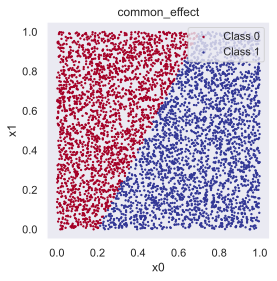

In [2]:
dataset_name = "common_effect"
vars = Constants( dataset_name )
data_common_effect = Dataset( dataset_name, vars.DATASET_PATH,"$$y(x_0, x_1, x_2) = \| 3x_0 - x_1 \|$$", "y")
data_common_effect.visualize_data2D()


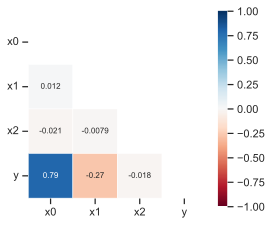

In [4]:
corr_mat = data_common_effect.correlation_matrix(text_size=8)

### Baysian Network Classifiers

In [8]:
learn_methods = ["GHC", "NaiveBayes", "Chow-Liu", "Tabu" ]
BNclfs = []
BNclfs_bn = []
for method in learn_methods:
  print("METHOD " + method)
  BNclf = BayesianNet( isLoadModel = False, dataset = data_common_effect)
  BNclf.applyClassifier(saveModel=True, learningMethod=method)
  if method != "NaiveBayes":
    BNclf.plot_decision_boundary( size=5, cmap=plt.cm.RdBu)

  BNclfs.append( BNclf )
  BNclfs_bn.append( BNclf.clf.bn)

METHOD GHC
Writing model to saved_models\BayesianNetwork_common_effect_GHC.net
METHOD NaiveBayes
Writing model to saved_models\BayesianNetwork_common_effect_NaiveBayes.net
METHOD Chow-Liu
Writing model to saved_models\BayesianNetwork_common_effect_Chow-Liu.net
METHOD Tabu
Writing model to saved_models\BayesianNetwork_common_effect_Tabu.net


In [9]:
gnb.sideBySide(*BNclfs_bn, captions=learn_methods)

G <!-- x1 --> x1 x1 <!-- y --> y y <!-- x1->y --> x1->y <!-- x2 --> x2 x2 <!-- x0 --> x0 x0 <!-- x0->y --> x0->y GHC,G <!-- x1 --> x1 x1 <!-- y --> y y <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 <!-- y->x2 --> y->x2 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 NaiveBayes,G <!-- x1 --> x1 x1 <!-- x2 --> x2 x2 <!-- x1->x2 --> x1->x2 <!-- y --> y y <!-- y->x1 --> y->x1 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 Chow-Liu,G <!-- x1 --> x1 x1 <!-- y --> y y <!-- y->x1 --> y->x1 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 <!-- x2 --> x2 x2 <!-- x0->x1 --> x0->x1 Tabu


Naive Bayes: Precision = 0.9184 Recall = 0.9282


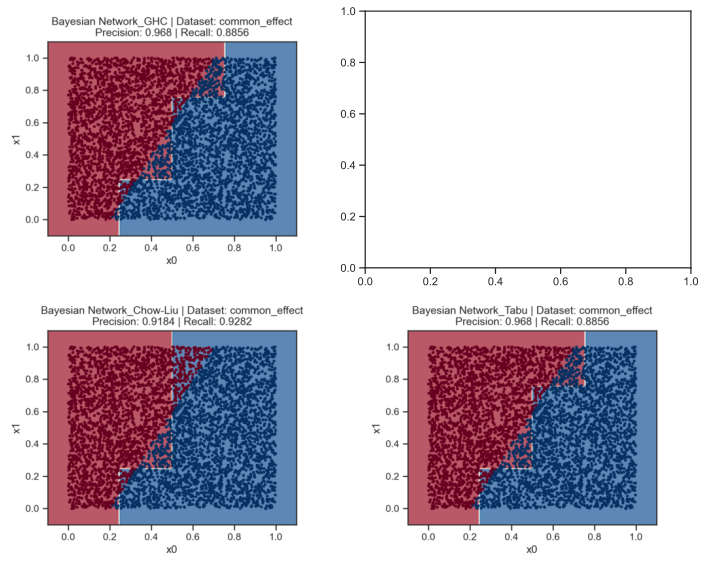

In [10]:
f, axarr = plt.subplots(2,2, figsize=(10, 8))
axs = axarr.flatten()
for i, ax in zip(range(0,len(BNclfs)), axs):
  if learn_methods[i] == "NaiveBayes":
    print("Naive Bayes: Precision = " + str(BNclfs[i].clf_results["precision"]) + " Recall = " + str(BNclfs[i].clf_results["recall"]))
    continue
  ax.imshow(mpimg.imread(BNclfs[i].decisionBoundary))
  ax.grid(False)
  ax.set_axis_off()
plt.tight_layout()

### Generating Explanations

#### Investigating Conditional Independence

Explores all the CI between 2 variables and computes the p-values w.r.t to a csv file.

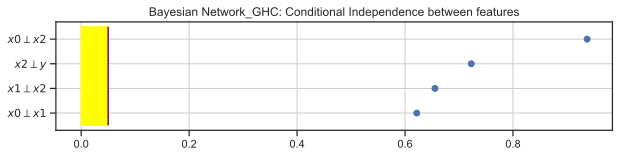

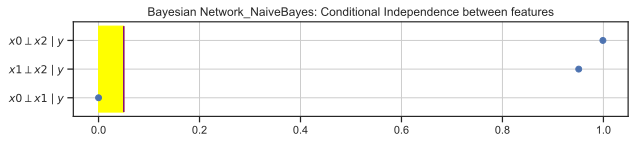

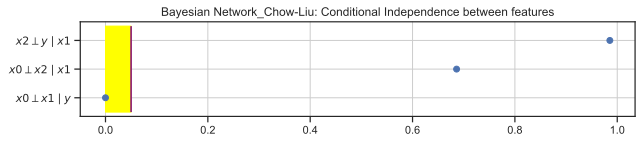

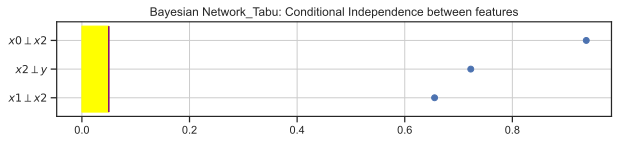

In [11]:
for i in range(0,len(BNclfs)):
  fig = expl.independenceListForPairs(BNclfs[i].clf.bn, vars.DATASET_PATH)
  plt.title( BNclfs[i].clf_name + ": Conditional Independence between features" )
  

The fisrt two classifiers (learning methods GHC and MIIC) correctly learned that all features are independent from each other. However, the Chow Liu network incorrectly learned a dependency between x0 and x1, because $x_0 \perp x_1~|~y = 0 $. The classifier that used the Tabu method failed to find independence between $x_1 \perp x_0$, however that does not seem to impact the model precision.


In [12]:
gnb.sideBySide(*BNclfs_bn, captions=learn_methods)

G <!-- x1 --> x1 x1 <!-- y --> y y <!-- x1->y --> x1->y <!-- x2 --> x2 x2 <!-- x0 --> x0 x0 <!-- x0->y --> x0->y GHC,G <!-- x1 --> x1 x1 <!-- y --> y y <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 <!-- y->x2 --> y->x2 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 NaiveBayes,G <!-- x1 --> x1 x1 <!-- x2 --> x2 x2 <!-- x1->x2 --> x1->x2 <!-- y --> y y <!-- y->x1 --> y->x1 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 Chow-Liu,G <!-- x1 --> x1 x1 <!-- y --> y y <!-- y->x1 --> y->x1 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 <!-- x2 --> x2 x2 <!-- x0->x1 --> x0->x1 Tabu


#### Conditional SHAP values

Feature Importance in % for Bayesian Network_GHC
{'x1': 0.9596237988179183, 'x2': 0.0, 'x0': 3.3868364300303155}
Feature Importance in % for Bayesian Network_NaiveBayes
{'x1': 0.4721604027288896, 'x2': 0.023567106532783974, 'x0': 3.364218486860284}
Feature Importance in % for Bayesian Network_Chow-Liu
{'x1': 0.47212955045361366, 'x2': 0.0034797656090092745, 'x0': 3.3642184868602847}
Feature Importance in % for Bayesian Network_Tabu
{'x1': 0.9527652512637442, 'x2': 3.92278802034221e-17, 'x0': 3.7842754288733405}


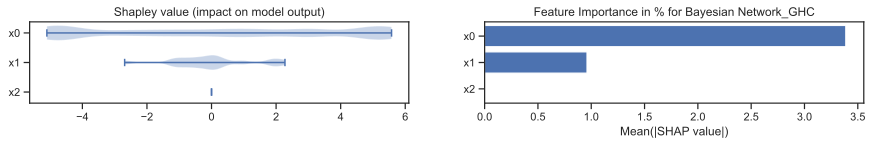

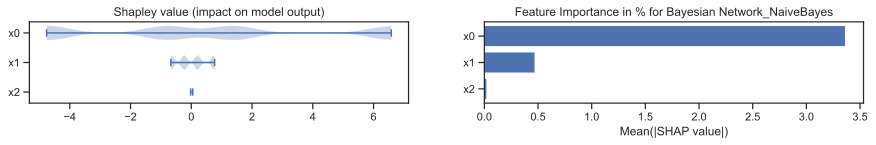

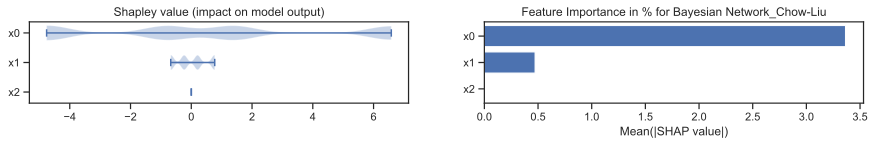

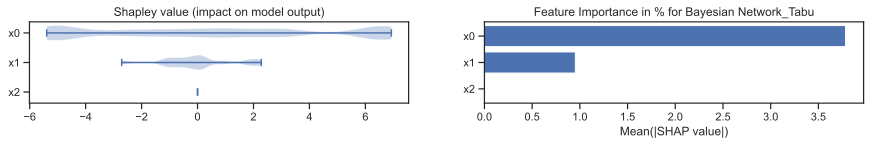

In [13]:
train = data_common_effect.dataset.sample(frac=1.0)
conditional_resshap = []
conditional_gumshap = []

for i in range(0, len(BNclfs)):
  gumshap = expl.ShapValues(BNclfs[i].clf.bn, 'y')
  result = gumshap.conditional(train, plot=True,plot_importance=True,percentage=False,)
  conditional_resshap.append(result)
  conditional_gumshap.append(gumshap)
  plt.title("Feature Importance in % for " + BNclfs[i].clf_name)
  plt.savefig(os.path.join(".","tmp", "shap", "conditional", data_common_effect.dataset_name + "_" + BNclfs[i].clf_name ) + ".png")
  print("Feature Importance in % for " + BNclfs[i].clf_name)
  print(result)

#### Marginal SHAP Values

Feature Importance in % for Bayesian Network_GHC
{'x1': 1.2106366064122625, 'x0': 3.791326962857993, 'x2': 0.0}
Feature Importance in % for Bayesian Network_NaiveBayes
{'x1': 0.4721909946015602, 'x0': 3.3767396739578834, 'x2': 0.028771594801637643}
Feature Importance in % for Bayesian Network_Chow-Liu
{'x1': 0.47219099460155994, 'x0': 3.3767396739578808, 'x2': 3.935740622296364e-17}
Feature Importance in % for Bayesian Network_Tabu
{'x1': 1.210636606412269, 'x0': 4.207956992320133, 'x2': 5.519658804094712e-17}


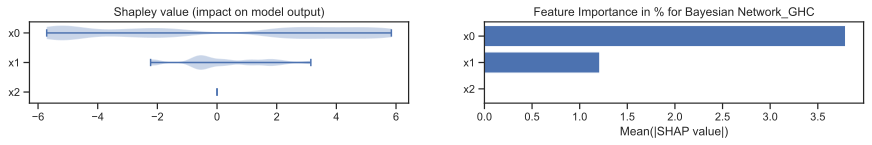

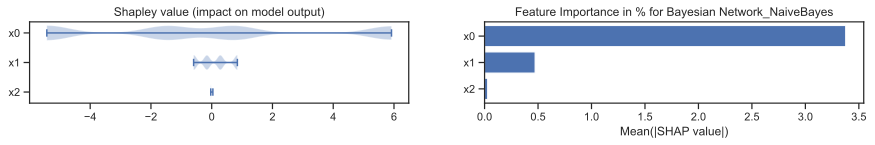

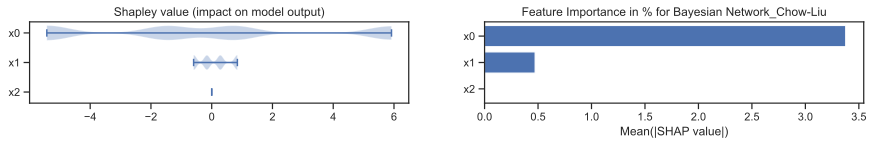

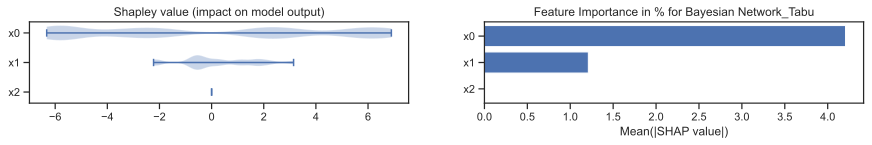

In [90]:
marginal_resshap = []
marginal_gumshap = []

for i in range(0, len(BNclfs)):
  gumshap = expl.ShapValues(BNclfs[i].clf.bn, 'y')
  marginal = gumshap.marginal(train, sample_size=10, plot=True,plot_importance=True,percentage=False)
  marginal_resshap.append(marginal)
  marginal_gumshap.append(gumshap)
  plt.title("Feature Importance in % for " + BNclfs[i].clf_name)
  plt.savefig(os.path.join(".","tmp", "shap", "marginal", data_common_effect.dataset_name + "_" + BNclfs[i].clf_name ) + ".png")
  print("Feature Importance in % for " + BNclfs[i].clf_name)
  print(marginal)

X2 is not part of the Markov Blanket and therefore its marginal contribution is null

#### Comparing with Kernel SHAP

In [67]:
import shap
shap.initjs()

##### Global Feature Importance

[Bayesian Network_GHC] Expected Value: [0.41469822 0.58530178]


  0%|          | 0/10 [00:00<?, ?it/s]

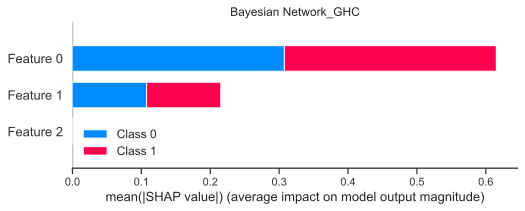

[Bayesian Network_NaiveBayes] Expected Value: [0.45728355 0.54271645]


  0%|          | 0/10 [00:00<?, ?it/s]

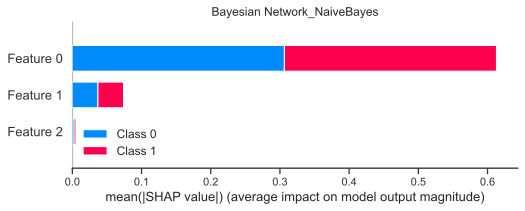

[Bayesian Network_Chow-Liu] Expected Value: [0.45679751 0.54320249]


  0%|          | 0/10 [00:00<?, ?it/s]

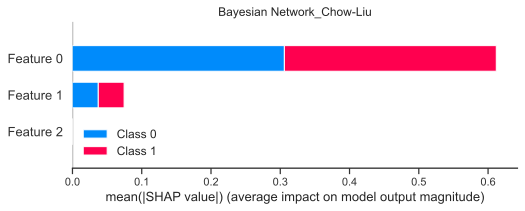

[Bayesian Network_Tabu] Expected Value: [0.41437548 0.58562452]


  0%|          | 0/10 [00:00<?, ?it/s]

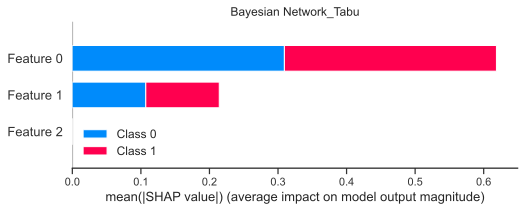

In [125]:
for clf in range(0,len(BNclfs)):
  explainer = shap.KernelExplainer(BNclfs[clf].clf.predict_proba, shap.sample(BNclfs[clf].Xtrain,10))
  expected_value = explainer.expected_value
  print("[" + BNclfs[clf].clf_name +"] "+ "Expected Value: " + str(expected_value))

  shap_values = explainer.shap_values(shap.sample(BNclfs[clf].Xtrain,10))
  plt.title(BNclfs[clf].clf_name)
  shap.summary_plot(shap_values, shap.sample(BNclfs[clf].Xtrain,10), plot_type="bar")
  


In [129]:
ax = gumshap.showShapValues(results = result, cmap="RdBu" )
ax

In [128]:
ola = expl.getInformation(BNclfs[0].clf.bn, )
HTML(ola)

### Generating Explanations for XGBoost

In [ ]:
from  lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer

In [ ]:
indx = 5

res = xgb.predict_proba([X_test[indx]])
print( "Prediction: " + str(np.argmax(res[0])) )

exp = explainer.explain_instance(X_test[indx], xgb.predict_proba, num_features=3)
fig = exp.as_pyplot_figure()

### Generating Explanations for Neural Net


In [ ]:
from  lime.lime_tabular import LimeTabularExplainer
explainer_nn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_nn

In [ ]:
predict_fn = lambda x:  1.0 if nn.predict(x) >= 0.5 else 0.0

In [ ]:
indx = 5

instance1 =  np.expand_dims(X_test[indx], axis=0) 
instance2 =  X_test[indx]

exp = explainer.explain_instance(X_test[indx], nn.predict, num_features=3)
fig = exp.as_pyplot_figure()

In [ ]:
explainer_bn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_bn